In [51]:
import numpy as np
import cv2
from PIL import Image, ImageDraw
import os
import random

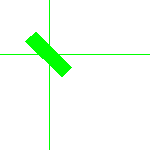

In [62]:
# 读取png图像
img0 = cv2.imread('D:/renwu/cuxian1.png')
img = img0[4450:4600, 4150:4300]
Image.fromarray(img)

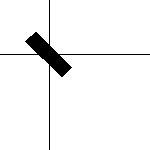

In [63]:
 # 将图像转换为灰度图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 对图像进行二值化处理
_, binary = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)
Image.fromarray(binary)

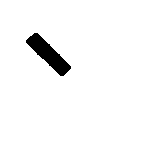

In [64]:
# 闭运算和细化
kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
Image.fromarray(closing)

In [65]:

rows, cols = binary.shape
result = np.copy(closing)

# 遍历图像中的每个像素
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
            # 检查相邻像素是否有白色像素
        neighbors = [
            binary[i - 1, j - 1], binary[i - 1, j], binary[i - 1, j + 1],
            binary[i, j - 1], binary[i, j + 1],
            binary[i + 1, j - 1], binary[i + 1, j], binary[i + 1, j + 1]
        ]
        has_white_neighbor = any(neighbor == 255 for neighbor in neighbors)
        if not has_white_neighbor:
                # 将不满足条件的像素置为白色
            result[i, j] = [ 255, 255, 255]

Image.fromarray(result)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [66]:
output_folder = 'D:/renwu/cuxianchuliwan/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
cv2.imwrite(os.path.join(output_folder, 'fix2.png'), result)

True

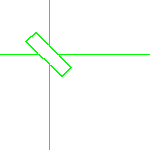

In [68]:
# 将图像转换为灰度图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 254, 255, cv2.THRESH_OTSU)
rows, cols = binary.shape
binary_padded = np.pad(binary, 1, mode='constant', constant_values=0)
binary_padded = binary_padded[1:-1, 1:-1]
binary_padded = binary_padded.astype(np.uint8)
    
# 定义用于检查相邻像素的卷积核
kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=np.uint8)
# 使用卷积操作检查相邻像素是否有白色像素
convolution_result = cv2.filter2D(binary_padded, -1, kernel)
mask = convolution_result > 0
result = np.copy(img)
result[~mask] = [255, 255, 255]
Image.fromarray(result)

In [50]:
output_folder = 'D:/renwu/cuxianchuliwan/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
cv2.imwrite(os.path.join(output_folder, 'fix.png'), result)

True

In [46]:
def detect_one_img(img, cfg):
    """
    修改后的函数，支持直接传入 result 图像。
    img: 输入图像（可以是 BGR 彩色图像或灰度图像）。
    cfg: 配置对象。
    """
    # 如果输入是彩色图像（3 通道），转换为灰度图像
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 如果输入不是二值图像，进行二值化处理
    if img.dtype != np.uint8 or np.max(img) > 1:
        _, img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    # 以下是原有逻辑
    elines = get_eline_faster(img, cfg)
    cfs = getlinks(elines, cfg)
    elines_group_by_line = []

    # 先遍历1-5纯血直线
    group_by_volume = {}
    for idx, eline in enumerate(elines):
        if eline.volume not in group_by_volume:
            group_by_volume[eline.volume] = []
        group_by_volume[eline.volume].append(idx)
    uf = UnionFind(len(elines))
    for it in range(1, 6):
        if it not in group_by_volume:
            continue
        for eline_idx in group_by_volume[it]:
            eline = elines[eline_idx]
            for eline2_idx in cfs.get_neighbors(eline_idx):
                eline2 = elines[eline2_idx]
                if (eline.color == eline2.color and eline.volume == eline2.volume and eline.dir_eq(eline2.dir)
                        and (eline.volume == 1 or (eline.k1 + eline2.k2) and (eline2.k1 + eline.k2))):
                    uf.union(eline_idx, eline2_idx)

    sets = uf.get_sets()
    # 剩余的线  用来再做一次上面的操作
    other_elines = []
    for i, set_ in enumerate(sets):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        if len(set_) >= cfg.MAX_CONTINUE:
            elines_group_by_line.append(set_)
        else:
            for j in set_:
                other_elines.append(j)

    # 混合遍历 , 大1 小1 等于
    group_by_volume = {}
    for idx in other_elines:
        eline = elines[idx]
        if eline.volume not in group_by_volume:
            group_by_volume[eline.volume] = []
        group_by_volume[eline.volume].append(idx)

    uf = UnionFind(len(elines))  # 重置并查集
    for key in group_by_volume.keys():
        for di in [-1, 0, 1]:
            if key + di in group_by_volume.keys():
                for eline1_idx in group_by_volume[key]:
                    eline1 = elines[eline1_idx]
                    for eline2_idx in cfs.get_neighbors(eline1_idx):
                        eline2 = elines[eline2_idx]
                        if eline1.color == eline2.color and eline2_idx in group_by_volume[key + di] and eline1.dir_eq(
                                eline2.dir) and (
                                eline1.volume == 1 or (eline1.k1 + eline2.k2) and (eline2.k1 + eline1.k2)):
                            uf.union(eline1_idx, eline2_idx)
    # 合并罢了
    sets = uf.get_sets()
    for i, set_ in enumerate(sets):
        if len(set_) > 1:
            elines_group_by_line.append(set_)
        else:
            if set_[0] in other_elines:
                elines_group_by_line.append(set_)

    len(elines_group_by_line)
    egbl = []  # 真的不知道该怎么起名了
    for group in elines_group_by_line:
        egbl.append([elines[i] for i in group])
    # 黏合线元为直线，包含上颜色
    lines = [merge_eline(group) for group in egbl]

    return lines, elines
lines, elines = detect_one_img(result, cfg)

result_img, lines, elines = detect_one_img(result, cfg)

# 显示结果
Image.fromarray(result_img)

NameError: name 'cfg' is not defined

In [47]:
lines, elines = detect_one_img(result, cfg)

NameError: name 'cfg' is not defined

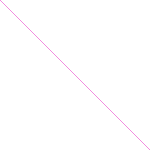

In [45]:
# 提取线段信息：基于连通区域
binary_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)  # 转换为灰度图像
_, binary_result = cv2.threshold(binary_result, 254, 255, cv2.THRESH_BINARY_INV)  # 反转二值化
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_result, connectivity=8)

elines = []
for i in range(1, num_labels):  # 跳过背景（标签 0）
    x, y, w, h, area = stats[i]
    if w > 1 or h > 1:  # 过滤掉单个像素点
        elines.append({"pt1": (x, y), "pt2": (x + w - 1, y + h - 1)})

# 第二段代码：在白色背景上绘制随机颜色的线段
white = np.ones_like(result) * 255
for el in elines:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, el["pt1"], el["pt2"], color, 1)

# 显示结果
Image.fromarray(white)

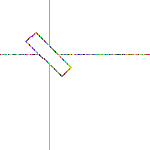

In [42]:
# 提取线段信息（按行和列分别提取）
elines = []

# 按行提取水平线段
for y in range(result.shape[0]):  # 遍历每一行
    line_segments = []
    for x in range(result.shape[1]):  # 遍历每一列
        if not np.array_equal(result[y, x], [255, 255, 255]):  # 如果像素不是白色
            if not line_segments:
                line_segments.append((x, y))  # 线段的起点
            else:
                line_segments.append((x, y))  # 线段的中间点
        else:
            if line_segments:
                elines.append({"pt1": line_segments[0], "pt2": line_segments[-1]})  # 存储线段
                line_segments = []  # 重置线段
    if line_segments:  # 处理行末尾的线段
        elines.append({"pt1": line_segments[0], "pt2": line_segments[-1]})

# 按列提取垂直线段
for x in range(result.shape[1]):  # 遍历每一列
    line_segments = []
    for y in range(result.shape[0]):  # 遍历每一行
        if not np.array_equal(result[y, x], [255, 255, 255]):  # 如果像素不是白色
            if not line_segments:
                line_segments.append((x, y))  # 线段的起点
            else:
                line_segments.append((x, y))  # 线段的中间点
        else:
            if line_segments:
                elines.append({"pt1": line_segments[0], "pt2": line_segments[-1]})  # 存储线段
                line_segments = []  # 重置线段
    if line_segments:  # 处理列末尾的线段
        elines.append({"pt1": line_segments[0], "pt2": line_segments[-1]})

# 第二段代码：在白色背景上绘制随机颜色的线段
white = np.ones_like(result) * 255
for el in elines:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, el["pt1"], el["pt2"], color, 1)

# 显示结果
Image.fromarray(white)

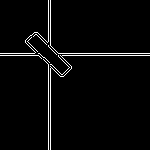

In [36]:
# 从 result 中提取线段信息
edges = cv2.Canny(result, 50, 150, apertureSize=3) # 使用 Canny 边缘检测
Image.fromarray(edges)

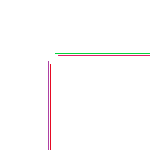

In [43]:
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

# 将线段信息存储到 elines 中
elines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]  # 提取线段的起点和终点
        elines.append({"pt1": (x1, y1), "pt2": (x2, y2)})  # 存储为字典

# 第二段代码：在白色背景上绘制随机颜色的线段
white = np.ones_like(result) * 255
for el in elines:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, el["pt1"], el["pt2"], color, 1)

# 显示结果
Image.fromarray(white)